---------------------
#### Classification : Breast cancer dataset
-----------------------

In [15]:
#pip install torchsummary

In [17]:
#pip install torchviz

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [18]:
from torchsummary import summary
from torchviz import make_dot

In [37]:
# Load and preprocess the dataset
data = load_breast_cancer()
X = data.data
y = data.target

In [38]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [40]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [42]:
# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [43]:
# Define the Perceptron model
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Single-layer perceptron

    def forward(self, x):
        x = self.linear(x)
        return torch.sigmoid(x)  # Sigmoid activation for binary classification

In [49]:
# Model initialization
# The input_dim determines the number of input features for the perceptron model.
# The perceptron is initialized with an input layer (nn.Linear) that matches the number of features 
# in the dataset.
# This ensures the perceptron can process the input data correctly for training and inference.

model = Perceptron(X_train.shape[1])  # Input dimension is the number of features
loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer     = optim.Adam(model.parameters(), lr=0.001)


In [50]:
summary(model, input_size=(1, input_dim))  # Input size with batch dimension

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 1]              31
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [46]:
# Generate a computational graph
sample_input = torch.randn(1, X_train.shape[1])  # Random sample input
model  = Perceptron(X_train.shape[1])
output = model(sample_input)  # Forward pass

graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("perceptron_model", format="png")  # Saves the graph as an image

'perceptron_model.png'

In [47]:
import matplotlib.pyplot as plt

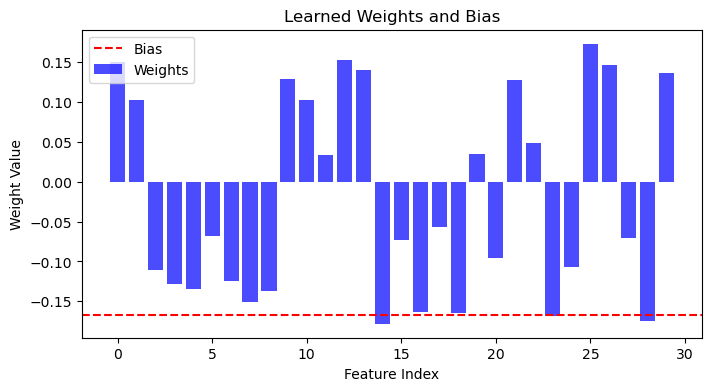

In [48]:
# Extract weights and biases from the linear layer
linear_layer = model.linear
weights      = linear_layer.weight.detach().numpy()
bias         = linear_layer.bias.detach().numpy()

# Plot weights and biases
plt.figure(figsize=(8, 4))
plt.bar(range(len(weights[0])), weights[0], color='blue', alpha=0.7, label='Weights')
plt.axhline(y=bias[0], color='red', linestyle='--', label='Bias')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Learned Weights and Bias')
plt.legend()
plt.show()


In [51]:
# Training with early stopping and loss tracking
num_epochs = 100
patience   = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
train_losses = []
val_losses = []
early_stopping_triggered = False

In [52]:
# Loop over epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss_epoch = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_function(outputs, targets)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        train_loss_epoch += loss.item()

    # Average training loss for this epoch
    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    with torch.no_grad():  # No gradients needed for validation
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss_epoch += loss.item()

    # Average validation loss for this epoch
    val_loss_epoch /= len(val_loader)
    val_losses.append(val_loss_epoch)

    # Print the losses for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_epoch:.4f}, Validation Loss: {val_loss_epoch:.4f}")

    # Early stopping check
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        epochs_without_improvement = 0  # Reset counter if we have improvement
    else:
        epochs_without_improvement += 1
    
    # Stop training if no improvement for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        early_stopping_triggered = True
        break

Epoch [1/100], Train Loss: 0.8957, Validation Loss: 0.8433
Epoch [2/100], Train Loss: 0.7923, Validation Loss: 0.7340
Epoch [3/100], Train Loss: 0.6887, Validation Loss: 0.6449
Epoch [4/100], Train Loss: 0.6172, Validation Loss: 0.5719
Epoch [5/100], Train Loss: 0.5483, Validation Loss: 0.5138
Epoch [6/100], Train Loss: 0.4999, Validation Loss: 0.4667
Epoch [7/100], Train Loss: 0.4679, Validation Loss: 0.4287
Epoch [8/100], Train Loss: 0.4282, Validation Loss: 0.3971
Epoch [9/100], Train Loss: 0.3989, Validation Loss: 0.3704
Epoch [10/100], Train Loss: 0.3786, Validation Loss: 0.3468
Epoch [11/100], Train Loss: 0.3534, Validation Loss: 0.3269
Epoch [12/100], Train Loss: 0.3321, Validation Loss: 0.3098
Epoch [13/100], Train Loss: 0.3194, Validation Loss: 0.2941
Epoch [14/100], Train Loss: 0.3008, Validation Loss: 0.2803
Epoch [15/100], Train Loss: 0.2868, Validation Loss: 0.2677
Epoch [16/100], Train Loss: 0.2834, Validation Loss: 0.2568
Epoch [17/100], Train Loss: 0.2669, Validation Lo

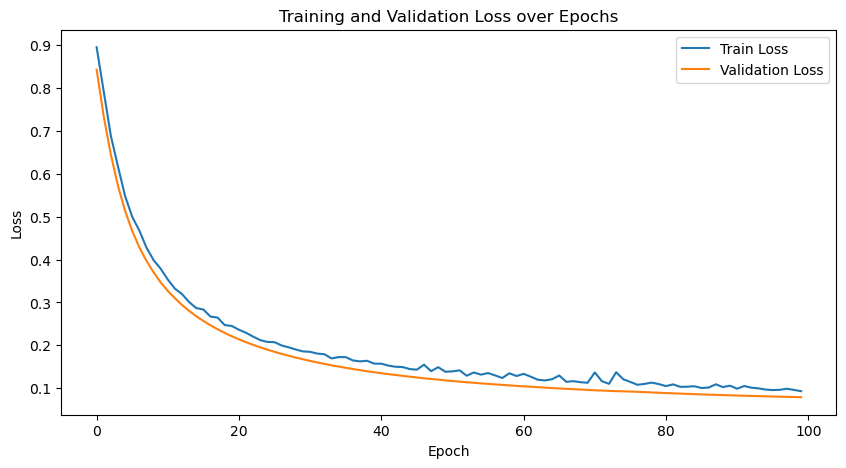

In [53]:
# Plotting the training and validation loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [58]:
# Evaluate the model

# sets the model in evaluation mode, which disables certain features like dropout and batch normalization 
# that are only used during training.
model.eval()

# Convert X_train and X_test to PyTorch tensors (if they are still NumPy arrays)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

# This context manager disables gradient calculation, which is important for inference (prediction) 
# because it saves memory and computations. You don’t need gradients when evaluating the model, 
# as you're not updating the model’s parameters.
with torch.no_grad():

    # The model is applied to X_train to get the predicted outputs. 
    # this code compares the output of the model to 0.5 (for binary classification). 
    # If the model's output is greater than or equal to 0.5, it's classified as class 1, 
    # otherwise as class 0. 
    # The result is cast to a floating point tensor (either 0.0 or 1.0).
    y_pred_train = (model(X_train_tensor) >= 0.5).float()
    y_pred_test  = (model(X_test_tensor)  >= 0.5).float()

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train.numpy())
test_accuracy  = accuracy_score(y_test,  y_pred_test.numpy())

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 97.80%
Test Accuracy: 98.25%


C:\Users\bhupe\AppData\Local\Temp\ipykernel_28336\4270658714.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)


In [59]:
test_conf_matrix = confusion_matrix(y_test.numpy(),  y_pred_test.numpy())
test_conf_matrix

array([[42,  1],
       [ 1, 70]], dtype=int64)